In [ ]:
import IPython.display
import librosa
import librosa.display
import pandas as pd
import seaborn as sns
import os
import struct
import json
import glob
import soundfile as sf
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
from datetime import datetime
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

#OUTPUT VALIDATION

In [ ]:
filenameOutputGun = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/DSE_gunshot.json"
filenameOutputSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/DSE_siren.json"
filenameOutputScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/DSE_scream.json"


NExp = 1              #1              #Identificación con número de experimento
samplerate = 22050
longitudMaxAudio = 4
valuesNmfcc = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45] #[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45]    #Valores de parametro a variar para el numero de coeficientes MFCC
valuesNfft = [256, 512, 1024, 2048, 4096]    #[256, 512, 1024, 2048, 4096]   #Valores de parametro a variar para la longitud de la FFT
valuesWinL = [256, 512, 1024, 2048, 4096]        #[256, 512, 1024, 2048, 4096] #Valores de parametro a variar para el tamaño de ventana, este debe ser menor o igual a NFFT, la función hace padding con 0
valuesHopL = [0.25, 0.5, 0.75, 1.0]                   #[0.25, 0.5, 0.75, 1.0]   #Valores de parametro a variar para el overlaping opuesto de hop_length
valuesKernelSize = [2, 3, 5, 7]                 #[2, 3, 5, 7]  #Valores de parametro de tamaño de kernel a variar dentro del modelo



def validateExperimentOut(filenameOutput):

  # 1. Read json file
  with open(filenameOutput, "r") as f:
      data = json.load(f)
      f.close()
  # 2. Update json object
  print(len(data["Experiments"]))
  #print(data["Experiments"][2024])
  #Experiment = data["Experiments"][0]
  #print("Type:", type(Experiment))
  #print('N_MFCC=', Experiment['N_MFCC'])

  NExp = 1
  Nexperiments = 0
  for Nmfcc in valuesNmfcc:                     #Loop para variar valores del parametro n_mfcc => Numero de coeficientes MFCC
    for Nfft in valuesNfft:                         #Loop para variar valores del parametro n_fft => Tamaño del la FFT
      for iterableNwinL in valuesWinL:              #Loop para variar valores del parametro Win_Length => Longitud de la ventana de muestreo
        if iterableNwinL<=Nfft:
          NwinL = iterableNwinL
        else:
          continue
        for iterableNhopL in valuesHopL:            #Loop para variar valores del parametro Hop_Length => Overlaping
          NhopL = int(iterableNhopL*NwinL)
          for k_size in valuesKernelSize:           #Loop para variar valores del parametro kernel size => Tamaño del kernel de capas convolucionales
            Experiment = data["Experiments"][Nexperiments]

            if(Experiment['N_MFCC']!=Nmfcc or Experiment['Nfft']!=Nfft or Experiment['NwinL']!=NwinL or Experiment['NhopL']!=NhopL or Experiment['Ksize']!=k_size or Experiment['NExp']!=NExp):
              print("NOT FOUND COINCIDENCE IN FOLLOW EXPERIMENT: ")
              print("EXPECTED:")
              print(f'NExp= {NExp}, N_MFCC= {Nmfcc}, Nfft= {Nfft}, NwinL= {NwinL}, NhopL= {NhopL}, k_size= {k_size}')
              print("FOUND:")
              print('NExp= ', Experiment['NExp'])
              print('N_MFCC= ', Experiment['N_MFCC'])
              print('Nfft= ', Experiment['Nfft'])
              print('NwinL= ', Experiment['NwinL'])
              print('NhopL= ', Experiment['NhopL'])
              print('k_size=', Experiment['Ksize'])
              return
            NExp += 1
            Nexperiments = Nexperiments + 1

  print('Output File Experiments Correct')
  print(f'Numero total experimentos debieron correrse = {Nexperiments},')
  print(f'Numero total experimentos corridos = { len(data["Experiments"])},')


filenameOutputGun = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/DSE_gunshot.json"
filenameOutputSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/DSE_siren.json"
filenameOutputScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/DSE_scream.json"

#validateExperimentOut(filenameOutputGun)
validateExperimentOut(filenameOutputSiren)
#validateExperimentOut(filenameOutputScream)

Experiment = {
  'NExp': NExp,
  'N_MFCC': '',
  'Nfft': '',
  'NwinL': '',
  'NhopL': '',
  'Ksize': '',
  'durationAvgPreprocs': '',
  #'models': models,
  #'histories': histories,
  'reports': '',
  'cmatrixs': '',
  'trainAcc': '',
  'testAcc': '',
  'trainTimes': '',
  'numberEpochsRan': '',
  'specGPU': '',
  'specCPU': '',
  'specCore': ''
}




3600
Output File Experiments Correct
Numero total experimentos debieron correrse = 3600,
Numero total experimentos corridos = 3600,


#OUTPUT ALL DATASET

In [ ]:
def createALLDataOut(filenameOutput, ALLDataOutputPath):
  import datetime
  import pandas as pd     # Import pandas library

  # 1. Read json file
  with open(filenameOutput, "r") as f:
      data = json.load(f)
      f.close()
  # 2. Update json object
  print(len(data["Experiments"]))

  Nexperiments = 0

  dfExperiments = pd.DataFrame(columns=['NExp', 'NMFCC', 'Nfft', 'NwinL', 'NhopL', 'Overlap', 'Ksize', 'NRep','AVGPreprocesTime', 'TrainTime', 'F1Score', 'TestAcc', 'EpochsRan'])      # Create the pandas DataFrame with column name is provided explicitly
  for expIterator in range(len(data["Experiments"])):
    Experiment = data["Experiments"][expIterator]
    NExp = Experiment['NExp']
    NMFCC = Experiment['N_MFCC']
    Nfft = Experiment['Nfft']
    NwinL = Experiment['NwinL']
    NhopL = Experiment['NhopL']
    Overlap = float(1-NhopL/NwinL)
    Ksize = Experiment['Ksize']
    timeRef = datetime.datetime.strptime('00:00:00.0',"%H:%M:%S.%f")
    durationTimePrep = datetime.datetime.strptime(Experiment['durationAvgPreprocs'], '%H:%M:%S.%f')
    AVGPreprocesTime = durationTimePrep - timeRef
    trainTimes = datetime.timedelta(days=0, seconds=0, microseconds=0, milliseconds=0, minutes=0, hours=0, weeks=0)
    for i in range(5):
      NRep = i+1
      report = Experiment['reports'][i]
      F1Score = float(report.split()[7])*100
      TestAcc = float(report.split()[15])*100
      trainTime = Experiment['trainTimes'][i]
      #print(NExp, NRep)
      #print(trainTime)
      trainTime = datetime.datetime.strptime(Experiment['trainTimes'][i], '%H:%M:%S.%f')
      TrainTime = trainTime - timeRef
      EpochsRan = Experiment['numberEpochsRan'][i]

      # Insert Dict to the dataframe using DataFrame.concat()
      newExperiment = {'NExp':NExp, 'NMFCC':NMFCC, 'Nfft':Nfft, 'NwinL':NwinL, 'NhopL':NhopL, 'Overlap': Overlap, 'Ksize':Ksize, 'NRep':NRep,  'AVGPreprocesTime':AVGPreprocesTime, 'TrainTime':TrainTime, 'F1Score':F1Score, 'TestAcc':TestAcc, 'EpochsRan':EpochsRan}
      newExperiment = pd.DataFrame([newExperiment.values()], columns=dfExperiments.columns)
      dfExperiments = pd.concat([dfExperiments, newExperiment], ignore_index=True)



    #EpochsRan = round(sum(Experiment['numberEpochsRan']) / len(Experiment['numberEpochsRan']))

    '''print("DATA OF EXPERIMENT:")
    print('Nfft= ', Nfft)
    print('NwinL= ', NwinL)
    print('NhopL= ', Experiment['NhopL'])
    print('Overlap= ', Overlap)
    print('k_size=', Ksize)
    print('AVG durationAvgPreprocs= ',AVGPreprocesTime)
    print('AVG trainTime= ', AVGTrainTime)
    print('AVG f1-scores= ', F1Score)
    print('AVG testAccs= ', TestAcc)
    print('AVG EpochsRan= ', EpochsRan)'''


    '''print('N_MFCC= ', Experiment['N_MFCC'])
    print('Nfft= ', Experiment['Nfft'])
    print('NwinL= ', Experiment['NwinL'])
    print('NhopL= ', Experiment['NhopL'])
    print('k_size=', Experiment['Ksize'])
    print('durationAvgPreprocs= ', Experiment['durationAvgPreprocs'])
    print('reports= ', Experiment['reports'][0])
    print('cmatrixs= ', Experiment['cmatrixs'])
    print('trainAcc= ', Experiment['trainAcc'])
    print('testAcc=', Experiment['testAcc'])
    print('trainTimes= ', Experiment['trainTimes'])
    print('numberEpochsRan= ', Experiment['numberEpochsRan'])
    print('specGPU= ', Experiment['specGPU'])
    print('specCPU= ', Experiment['specCPU'])
    print('specCore=', Experiment['specCore'])'''

  #Export dataframe of experiments
  ALLDataOutputPath
  dfExperiments.to_csv(ALLDataOutputPath)
  #dfExperiments.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/output_data/AVG_data_out_gunshot.csv')
  print("FILE SAVED CORRECT WAY")
  print(dfExperiments.shape)


filenameOutputGun = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/DSE_gunshot.json"
ALLDataOutputPathGun = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/ALL_data_out_gunshot.csv"

filenameOutputSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/DSE_siren.json"
ALLDataOutputPathSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/ALL_data_out_siren.csv"

filenameOutputScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/DSE_scream.json"
ALLDataOutputPathScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/ALL_data_out_scream.csv"



#createALLDataOut(filenameOutputGun, ALLDataOutputPathGun)
createALLDataOut(filenameOutputSiren, ALLDataOutputPathSiren)
#createALLDataOut(filenameOutputScream, ALLDataOutputPathScream)

3600
FILE SAVED CORRECT WAY
(18000, 13)




#OUTPUT AVERAGE DATASET

In [ ]:

def createAVGDataOut(filenameOutput, AVGDataOutputPath):
  import datetime
  import pandas as pd     # Import pandas library

  # 1. Read json file
  with open(filenameOutput, "r") as f:
      data = json.load(f)
      f.close()
  # 2. Update json object
  print(len(data["Experiments"]))

  Nexperiments = 0

  dfExperiments = pd.DataFrame(columns=['NExp', 'NMFCC', 'Nfft', 'NwinL', 'NhopL', 'Overlap', 'Ksize', 'AVGPreprocesTime', 'AVGTrainTime', 'F1Score', 'TestAcc', 'EpochsRan'])      # Create the pandas DataFrame with column name is provided explicitly
  for expIterator in range(len(data["Experiments"])):
    Experiment = data["Experiments"][expIterator]
    NExp = Experiment['NExp']
    NMFCC = Experiment['N_MFCC']
    Nfft = Experiment['Nfft']
    NwinL = Experiment['NwinL']
    NhopL = Experiment['NhopL']
    Overlap = float(1-NhopL/NwinL)
    Ksize = Experiment['Ksize']
    timeRef = datetime.datetime.strptime('00:00:00.0',"%H:%M:%S.%f")
    durationTimePrep = datetime.datetime.strptime(Experiment['durationAvgPreprocs'], '%H:%M:%S.%f')
    AVGPreprocesTime = durationTimePrep - timeRef
    f1_scores = 0
    testAccs = 0
    trainTimes = datetime.timedelta(days=0, seconds=0, microseconds=0, milliseconds=0, minutes=0, hours=0, weeks=0)
    for i in range(5):
      report = Experiment['reports'][i]
      f1_scores += float(report.split()[7])*100
      testAccs += float(report.split()[15])*100
      trainTime = Experiment['trainTimes'][i]
      trainTime = datetime.datetime.strptime(Experiment['trainTimes'][i], '%H:%M:%S.%f')
      trainTime = trainTime - timeRef
      trainTimes = trainTimes + trainTime

    AVGTrainTime = trainTimes/5
    F1Score = f1_scores/5
    TestAcc = testAccs/5
    EpochsRan = round(sum(Experiment['numberEpochsRan']) / len(Experiment['numberEpochsRan']))

    '''print("DATA OF EXPERIMENT:")
    print('Nfft= ', Nfft)
    print('NwinL= ', NwinL)
    print('NhopL= ', Experiment['NhopL'])
    print('Overlap= ', Overlap)
    print('k_size=', Ksize)
    print('AVG durationAvgPreprocs= ',AVGPreprocesTime)
    print('AVG trainTime= ', AVGTrainTime)
    print('AVG f1-scores= ', F1Score)
    print('AVG testAccs= ', TestAcc)
    print('AVG EpochsRan= ', EpochsRan)'''

    # Insert Dict to the dataframe using DataFrame.append()
    newExperiment = {'NExp':NExp, 'NMFCC':NMFCC, 'Nfft':Nfft, 'NwinL':NwinL, 'NhopL':NhopL, 'Overlap': Overlap, 'Ksize':Ksize, 'AVGPreprocesTime':AVGPreprocesTime, 'AVGTrainTime':AVGTrainTime, 'F1Score':F1Score, 'TestAcc':TestAcc, 'EpochsRan':EpochsRan}
    newExperiment = pd.DataFrame([newExperiment.values()], columns=dfExperiments.columns)
    dfExperiments = pd.concat([dfExperiments, newExperiment], ignore_index=True)

    '''print('N_MFCC= ', Experiment['N_MFCC'])
    print('Nfft= ', Experiment['Nfft'])
    print('NwinL= ', Experiment['NwinL'])
    print('NhopL= ', Experiment['NhopL'])
    print('k_size=', Experiment['Ksize'])
    print('durationAvgPreprocs= ', Experiment['durationAvgPreprocs'])
    print('reports= ', Experiment['reports'][0])
    print('cmatrixs= ', Experiment['cmatrixs'])
    print('trainAcc= ', Experiment['trainAcc'])
    print('testAcc=', Experiment['testAcc'])
    print('trainTimes= ', Experiment['trainTimes'])
    print('numberEpochsRan= ', Experiment['numberEpochsRan'])
    print('specGPU= ', Experiment['specGPU'])
    print('specCPU= ', Experiment['specCPU'])
    print('specCore=', Experiment['specCore'])'''

  #Export dataframe of experiments
  AVGDataOutputPath
  dfExperiments.to_csv(AVGDataOutputPath)
  #dfExperiments.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/output_data/AVG_data_out_gunshot.csv')
  print("FILE SAVED CORRECT WAY")
  print(dfExperiments.shape)


filenameOutputGun = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/DSE_gunshot.json"
AVGDataOutputPathGun = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_gunshot.csv"

filenameOutputSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/DSE_siren.json"
AVGDataOutputPathSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_siren.csv"

filenameOutputScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/DSE_scream.json"
AVGDataOutputPathScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_scream.csv"



#createAVGDataOut(filenameOutputGun, AVGDataOutputPathGun)
createAVGDataOut(filenameOutputSiren, AVGDataOutputPathSiren)
#createAVGDataOut(filenameOutputScream, AVGDataOutputPathScream)




3600
FILE SAVED CORRECT WAY
(3600, 12)


#OUTPUT BEST RESULT DATASET

In [ ]:

def createBestDataOut(filenameOutput, BestDataOutputPath):
  import datetime
  import pandas as pd     # Import pandas library

  # 1. Read json file
  with open(filenameOutput, "r") as f:
      data = json.load(f)
      f.close()
  # 2. Update json object
  print(len(data["Experiments"]))

  Nexperiments = 0

  dfExperiments = pd.DataFrame(columns=['NExp', 'NMFCC', 'Nfft', 'NwinL', 'NhopL', 'Overlap', 'Ksize', 'AVGPreprocesTime', 'TrainTime', 'F1Score', 'TestAcc', 'EpochsRan'])      # Create the pandas DataFrame with column name is provided explicitly
  for expIterator in range(len(data["Experiments"])):
    Experiment = data["Experiments"][expIterator]
    NExp = Experiment['NExp']
    NMFCC = Experiment['N_MFCC']
    Nfft = Experiment['Nfft']
    NwinL = Experiment['NwinL']
    NhopL = Experiment['NhopL']
    Overlap = float(1-NhopL/NwinL)
    Ksize = Experiment['Ksize']
    timeRef = datetime.datetime.strptime('00:00:00.0',"%H:%M:%S.%f")
    durationTimePrep = datetime.datetime.strptime(Experiment['durationAvgPreprocs'], '%H:%M:%S.%f')
    AVGPreprocesTime = durationTimePrep - timeRef
    f1_scores = 0
    testAccs = 0
    trainTimes = datetime.timedelta(days=0, seconds=0, microseconds=0, milliseconds=0, minutes=0, hours=0, weeks=0)
    report = Experiment['reports'][0]
    f1_score = float(report.split()[7])*100
    testAcc = float(report.split()[15])*100
    trainTime = Experiment['trainTimes'][0]
    trainTime = datetime.datetime.strptime(Experiment['trainTimes'][0], '%H:%M:%S.%f')
    trainTime = trainTime - timeRef
    EpochsRan = Experiment['numberEpochsRan'][0]
    for i in range(5):
      report = Experiment['reports'][i]
      f1_scores = float(report.split()[7])*100
      testAccs = float(report.split()[15])*100
      #print(f1_scores)
      if(f1_scores>f1_score):
        f1_score = f1_scores
        testAcc = testAccs
        trainTime = Experiment['trainTimes'][i]
        trainTime = datetime.datetime.strptime(Experiment['trainTimes'][i], '%H:%M:%S.%f')
        trainTime = trainTime - timeRef
        EpochsRan = Experiment['numberEpochsRan'][i]
      elif(f1_scores==f1_score):
        if(testAccs>testAcc):
          f1_score = f1_scores
          testAcc = testAccs
          trainTime = Experiment['trainTimes'][i]
          trainTime = datetime.datetime.strptime(Experiment['trainTimes'][i], '%H:%M:%S.%f')
          trainTime = trainTime - timeRef
          EpochsRan = Experiment['numberEpochsRan'][i]


    TrainTime = trainTime
    F1Score = f1_score
    TestAcc = testAcc


    '''print("DATA OF EXPERIMENT:")
    print('Nfft= ', Nfft)
    print('NwinL= ', NwinL)
    print('NhopL= ', Experiment['NhopL'])
    print('Overlap= ', Overlap)
    print('k_size=', Ksize)
    print('AVG durationAvgPreprocs= ',AVGPreprocesTime)
    print('AVG trainTime= ', AVGTrainTime)
    print('AVG f1-scores= ', F1Score)
    print('AVG testAccs= ', TestAcc)
    print('AVG EpochsRan= ', EpochsRan)'''

    # Insert Dict to the dataframe using DataFrame.append()
    newExperiment = {'NExp':NExp, 'NMFCC':NMFCC, 'Nfft':Nfft, 'NwinL':NwinL, 'NhopL':NhopL, 'Overlap': Overlap, 'Ksize':Ksize, 'AVGPreprocesTime':AVGPreprocesTime, 'TrainTime':TrainTime, 'F1Score':F1Score, 'TestAcc':TestAcc, 'EpochsRan':EpochsRan}
    newExperiment = pd.DataFrame([newExperiment.values()], columns=dfExperiments.columns)
    dfExperiments = pd.concat([dfExperiments, newExperiment], ignore_index=True)

    '''print('N_MFCC= ', Experiment['N_MFCC'])
    print('Nfft= ', Experiment['Nfft'])
    print('NwinL= ', Experiment['NwinL'])
    print('NhopL= ', Experiment['NhopL'])
    print('k_size=', Experiment['Ksize'])
    print('durationAvgPreprocs= ', Experiment['durationAvgPreprocs'])
    print('reports= ', Experiment['reports'][0])
    print('cmatrixs= ', Experiment['cmatrixs'])
    print('trainAcc= ', Experiment['trainAcc'])
    print('testAcc=', Experiment['testAcc'])
    print('trainTimes= ', Experiment['trainTimes'])
    print('numberEpochsRan= ', Experiment['numberEpochsRan'])
    print('specGPU= ', Experiment['specGPU'])
    print('specCPU= ', Experiment['specCPU'])
    print('specCore=', Experiment['specCore'])'''

  #Export dataframe of experiments
  #AVGDataOutputPath
  dfExperiments.to_csv(BestDataOutputPath)
  #dfExperiments.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/output_data/AVG_data_out_gunshot.csv')
  print("FILE SAVED CORRECT WAY")
  print(dfExperiments.shape)


filenameOutputGun = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/DSE_gunshot.json"
BestDataOutputPathGun = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/Best_data_out_gunshot.csv"

filenameOutputSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/DSE_siren.json"
BestDataOutputPathSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/Best_data_out_siren.csv"

filenameOutputScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/DSE_scream.json"
BestDataOutputPathScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/Best_data_out_scream.csv"



#createBestDataOut(filenameOutputGun, BestDataOutputPathGun)
createBestDataOut(filenameOutputSiren, BestDataOutputPathSiren)
#createBestDataOut(filenameOutputScream, BestDataOutputPathScream)

3600
FILE SAVED CORRECT WAY
(3600, 12)


#ADD FLOPS PER MODEL IN OUTPUT DATA FILES

In [ ]:
# Constructing model with RELu and SoftMax activation functions:
# Constructing model with RELu and SoftMax activation functions:
def getModel(num_rows, num_columns, num_channels, num_labels, k_size):
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=k_size, input_shape=(num_rows, num_columns, num_channels), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=32, kernel_size=k_size, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, kernel_size=k_size, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=128, kernel_size=k_size, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(num_labels, activation='softmax'))
    return model

In [ ]:
import tensorflow as tf
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder
print('TensorFlow:', tf.__version__)

model1 = tf.keras.applications.ResNet50()
model2 = tf.keras.applications.EfficientNetV2B0(weights=None)

def get_flops(model):
  forward_pass = tf.function(
      model.call,
      input_signature=[tf.TensorSpec(shape=(1,) + model.input_shape[1:])])

  graph_info = profile(forward_pass.get_concrete_function().graph,
                          options=ProfileOptionBuilder.float_operation())

  # The //2 is necessary since `profile` counts multiply and accumulate
  # as two flops, here we report the total number of multiply accumulate ops
  flops = graph_info.total_float_ops // 2
  #print('Flops: {:,}'.format(flops))
  return flops

print(get_flops(model1))
print(get_flops(model2))

TensorFlow: 2.12.0
102967424/102967424 [==============================] - 1s 0us/step


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


3864223160
723851057


In [ ]:
filenameOutputGun = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/DSE_gunshot.json"
AVGDataOutputPathGun = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_gunshot.csv"
AVGDataOutputPathGunFLOPS = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_gunshot_flops.csv"
BestDataOutputPathGun = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/Best_data_out_gunshot.csv"
BestDataOutputPathGunFLOPS = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/Best_data_out_gunshot.csv"

filenameOutputSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/DSE_siren.json"
AVGDataOutputPathSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_siren.csv"
AVGDataOutputPathSirenFLOPS = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_siren_flops.csv"
BestDataOutputPathSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/Best_data_out_siren.csv"
BestDataOutputPathSirenFLOPS = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/Best_data_out_siren.csv"

filenameOutputScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/DSE_scream.json"
AVGDataOutputPathScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_scream.csv"
AVGDataOutputPathScreamFLOPS = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_scream_flops.csv"
BestDataOutputPathScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/Best_data_out_scream.csv"
BestDataOutputPathScreamFLOPS = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/Best_data_out_scream.csv"

NExp = 1              #1              #Identificación con número de experimento
samplerate = 22050
longitudMaxAudio = 4
valuesNmfcc = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45] #[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45]    #Valores de parametro a variar para el numero de coeficientes MFCC
valuesNfft = [256, 512, 1024, 2048, 4096]    #[256, 512, 1024, 2048, 4096]   #Valores de parametro a variar para la longitud de la FFT
valuesWinL = [256, 512, 1024, 2048, 4096]        #[256, 512, 1024, 2048, 4096] #Valores de parametro a variar para el tamaño de ventana, este debe ser menor o igual a NFFT, la función hace padding con 0
valuesHopL = [0.25, 0.5, 0.75, 1.0]                   #[0.25, 0.5, 0.75, 1.0]   #Valores de parametro a variar para el overlaping opuesto de hop_length
valuesKernelSize = [2, 3, 5, 7]                 #[2, 3, 5, 7]  #Valores de parametro de tamaño de kernel a variar dentro del modelo



def addFLOPStoExperiment(filenameOutput, newfilenameOutput, siren=False):

  # 1. Read  file
  dfExperiments = pd.read_csv(filenameOutput, index_col=0)
  #print(dfExperiments)

  Nexperiments = 0
  for Nmfcc in valuesNmfcc:                     #Loop para variar valores del parametro n_mfcc => Numero de coeficientes MFCC
    for Nfft in valuesNfft:                         #Loop para variar valores del parametro n_fft => Tamaño del la FFT
      for iterableNwinL in valuesWinL:              #Loop para variar valores del parametro Win_Length => Longitud de la ventana de muestreo
        if iterableNwinL<=Nfft:
          NwinL = iterableNwinL
        else:
          continue
        for iterableNhopL in valuesHopL:            #Loop para variar valores del parametro Hop_Length => Overlaping
          NhopL = int(iterableNhopL*NwinL)
          num_rows = Nmfcc
          num_columns = int(samplerate*longitudMaxAudio/NhopL) + int(samplerate*longitudMaxAudio/NhopL*0.05)  #Calculo longitud de salida de mfcc con 5% de tolerancia para longitud de audios
          if(siren==True):
            num_columns = int(samplerate*longitudMaxAudio/NhopL) + int(samplerate*longitudMaxAudio/NhopL*0.07)
          num_channels = 1
          num_labels = 2

          for k_size in valuesKernelSize:           #Loop para variar valores del parametro kernel size => Tamaño del kernel de capas convolucionales

            model = getModel(num_rows, num_columns, num_channels, num_labels, k_size)
            #Se compila el modelo con la función de perdida de crosentrpía categorica
            model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

            #Obtener los FLOPS para cada modelo

            modelFLOPS = get_flops(model)

            #predict('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/UrbanSounds8k/UrbanSound8K/audio/fold7/102853-8-0-1.wav', model, Nmfcc, Nfft, NhopL, NwinL)
            # Generate a print
            #model.summary()

            Experiment = dfExperiments.loc[(dfExperiments['NMFCC']==Nmfcc) & (dfExperiments['Nfft']==Nfft) & (dfExperiments['NwinL']==NwinL) & (dfExperiments['NhopL']==NhopL) & (dfExperiments['Ksize']==k_size)]
            #print(Experiment.index)
            dfExperiments.loc[Experiment.index, 'FLOPS'] = modelFLOPS

            Nexperiments = Nexperiments + 1
  print(dfExperiments)
  dfExperiments.to_csv(newfilenameOutput)
  #dfExperiments.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/output_data/AVG_data_out_gunshot.csv')
  print("FILE SAVED CORRECT WAY")
  print(dfExperiments.shape)


#addFLOPStoExperiment(AVGDataOutputPathGun, AVGDataOutputPathGunFLOPS)
addFLOPStoExperiment(AVGDataOutputPathSiren, AVGDataOutputPathSirenFLOPS, siren=True)
#addFLOPStoExperiment(AVGDataOutputPathScream, AVGDataOutputPathScreamFLOPS)
#addFLOPStoExperiment(BestDataOutputPathGun, BestDataOutputPathGunFLOPS)
addFLOPStoExperiment(BestDataOutputPathSiren, BestDataOutputPathSirenFLOPS, siren=True)
#addFLOPStoExperiment(BestDataOutputPathScream, BestDataOutputPathScreamFLOPS)


      NExp  NMFCC  Nfft  NwinL  NhopL  Overlap  Ksize        AVGPreprocesTime  \
0        1      3   256    256     64     0.75      2  0 days 00:00:00.019481   
1        2      3   256    256     64     0.75      3  0 days 00:00:00.019481   
2        3      3   256    256     64     0.75      5  0 days 00:00:00.019481   
3        4      3   256    256     64     0.75      7  0 days 00:00:00.019481   
4        5      3   256    256    128     0.50      2  0 days 00:00:00.014311   
...    ...    ...   ...    ...    ...      ...    ...                     ...   
3595  3596     45  4096   4096   3072     0.25      7  0 days 00:00:00.013938   
3596  3597     45  4096   4096   4096     0.00      2  0 days 00:00:00.015432   
3597  3598     45  4096   4096   4096     0.00      3  0 days 00:00:00.015432   
3598  3599     45  4096   4096   4096     0.00      5  0 days 00:00:00.015432   
3599  3600     45  4096   4096   4096     0.00      7  0 days 00:00:00.015432   

                AVGTrainTim

#ADD PREDIC TIMES PER MODEL AND TFLITE IN VIM3 TO OUTPUT DATA FILES

In [ ]:
filePredicTimesGunshot = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/dse_gunshot_times.json"
filePredicTimesSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/dse_siren_times.json"
filePredicTimesScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/dse_scream_times.json"

ALLDataOutputPathGunshot = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/ALL_data_out_gunshot.csv"
ALLDataOutputPathSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/ALL_data_out_siren.csv"
ALLDataOutputPathScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/ALL_data_out_scream.csv"


AVGDataOutputPathGunshot = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_gunshot.csv"
AVGDataOutputPathSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_siren.csv"
AVGDataOutputPathScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_scream.csv"


BestDataOutputPathGunshot = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/Best_data_out_gunshot.csv"
BestDataOutputPathSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/Best_data_out_siren.csv"
BestDataOutputPathScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/Best_data_out_scream.csv"


AVGDataOutputPathGunshotFLOPS = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_gunshot_flops.csv"
AVGDataOutputPathSirenFLOPS = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_siren_flops.csv"
AVGDataOutputPathScreamFLOPS = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_scream_flops.csv"


BestDataOutputPathGunshotFLOPS = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/Best_data_out_gunshot.csv"
BestDataOutputPathSirenFLOPS = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/Best_data_out_siren.csv"
BestDataOutputPathScreamFLOPS = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/Best_data_out_scream.csv"



#OUTPUT VALIDATION OF RAN EXPERIMENTS

In [ ]:
NExp = 1              #1              #Identificación con número de experimento
samplerate = 22050
longitudMaxAudio = 4
valuesNmfcc = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45] #[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45]    #Valores de parametro a variar para el numero de coeficientes MFCC
valuesNfft = [256, 512, 1024, 2048, 4096]    #[256, 512, 1024, 2048, 4096]   #Valores de parametro a variar para la longitud de la FFT
valuesWinL = [256, 512, 1024, 2048, 4096]        #[256, 512, 1024, 2048, 4096] #Valores de parametro a variar para el tamaño de ventana, este debe ser menor o igual a NFFT, la función hace padding con 0
valuesHopL = [0.25, 0.5, 0.75, 1.0]                   #[0.25, 0.5, 0.75, 1.0]   #Valores de parametro a variar para el overlaping opuesto de hop_length
valuesKernelSize = [2, 3, 5, 7]                 #[2, 3, 5, 7]  #Valores de parametro de tamaño de kernel a variar dentro del modelo



def validateExperimentOut(filenameOutput):

  # 1. Read json file
  with open(filenameOutput, "r") as f:
      data = json.load(f)
      f.close()
  # 2. Update json object
  print(len(data["Experiments"]))
  #print(data["Experiments"][2024])
  #Experiment = data["Experiments"][0]
  #print("Type:", type(Experiment))
  #print('N_MFCC=', Experiment['N_MFCC'])

  NExp = 1
  Nexperiments = 0
  for Nmfcc in valuesNmfcc:                     #Loop para variar valores del parametro n_mfcc => Numero de coeficientes MFCC
    for Nfft in valuesNfft:                         #Loop para variar valores del parametro n_fft => Tamaño del la FFT
      for iterableNwinL in valuesWinL:              #Loop para variar valores del parametro Win_Length => Longitud de la ventana de muestreo
        if iterableNwinL<=Nfft:
          NwinL = iterableNwinL
        else:
          continue
        for iterableNhopL in valuesHopL:            #Loop para variar valores del parametro Hop_Length => Overlaping
          NhopL = int(iterableNhopL*NwinL)
          for k_size in valuesKernelSize:           #Loop para variar valores del parametro kernel size => Tamaño del kernel de capas convolucionales
            Experiment = data["Experiments"][Nexperiments]

            if(Experiment['N_MFCC']!=Nmfcc or Experiment['Nfft']!=Nfft or Experiment['NwinL']!=NwinL or Experiment['NhopL']!=NhopL or Experiment['Ksize']!=k_size or Experiment['NExp']!=NExp):
              print("NOT FOUND COINCIDENCE IN FOLLOW EXPERIMENT: ")
              print("EXPECTED:")
              print(f'NExp= {NExp}, N_MFCC= {Nmfcc}, Nfft= {Nfft}, NwinL= {NwinL}, NhopL= {NhopL}, k_size= {k_size}')
              print("FOUND:")
              print('NExp= ', Experiment['NExp'])
              print('N_MFCC= ', Experiment['N_MFCC'])
              print('Nfft= ', Experiment['Nfft'])
              print('NwinL= ', Experiment['NwinL'])
              print('NhopL= ', Experiment['NhopL'])
              print('k_size=', Experiment['Ksize'])
              return
            NExp += 1
            Nexperiments = Nexperiments + 1

  print('Output File Experiments Correct')
  print(f'Numero total experimentos debieron correrse = {Nexperiments},')
  print(f'Numero total experimentos corridos = { len(data["Experiments"])},')


filePredicTimesGunshot = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/dse_gunshot_times.json"
filePredicTimesSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/dse_siren_times.json"
filePredicTimesScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/dse_scream_times.json"

#validateExperimentOut(filePredicTimesGunshot)
validateExperimentOut(filePredicTimesSiren)
#validateExperimentOut(filePredicTimesScream)


Experiment = {
      "Ksize": "",
      "NExp": "",
      "N_MFCC": "",
      "Nfft": "",
      "NhopL": "",
      "NwinL": "",
      "TFLitePredicTimes": [],
      "outAccs": [],
      "outAccsTFLite": [],
      "predicTimes": [],
      "preprocsTimes": [],
      "specCPU": "",
      "specCore": ""
    }


3600
Output File Experiments Correct
Numero total experimentos debieron correrse = 3600,
Numero total experimentos corridos = 3600,


#ADD TIMES TO ALL DATASET OUT

In [ ]:
def addTimestoALLDataOut(filePredicTimes, ALLDataOutputPath):
  import datetime
  import pandas as pd     # Import pandas library


  # 1. Read  file
  dfExperiments = pd.read_csv(ALLDataOutputPath, index_col=0)
  #print(dfExperiments)
  print(dfExperiments.shape)


  # 1. Read json file
  with open(filePredicTimes, "r") as f:
      data = json.load(f)
      f.close()
  # 2. Update json object
  print(len(data["Experiments"]))

  Nexperiments = 0

  #dfExperiments = pd.DataFrame(columns=['NExp', 'NMFCC', 'Nfft', 'NwinL', 'NhopL', 'Overlap', 'Ksize', 'NRep','AVGPreprocesTime', 'TrainTime', 'F1Score', 'TestAcc', 'EpochsRan'])      # Create the pandas DataFrame with column name is provided explicitly
  for expIterator in range(len(data["Experiments"])):
    Experiment = data["Experiments"][expIterator]
    NExp = Experiment['NExp']
    NMFCC = Experiment['N_MFCC']
    Nfft = Experiment['Nfft']
    NwinL = Experiment['NwinL']
    NhopL = Experiment['NhopL']
    Ksize = Experiment['Ksize']
    timeRef = datetime.datetime.strptime('00:00:00.0',"%H:%M:%S.%f")
    trainTimes = datetime.timedelta(days=0, seconds=0, microseconds=0, milliseconds=0, minutes=0, hours=0, weeks=0)
    for i in range(5):
      NRep = i+1
      VimPreprocessTime = Experiment['preprocsTimes'][i]
      #print(NExp, NRep)
      #print(VimPreprocessTime)
      VimPreprocessTime = datetime.datetime.strptime(Experiment['preprocsTimes'][i], '%H:%M:%S.%f')
      VimPreprocessTime = VimPreprocessTime - timeRef

      VimPredictTime = datetime.datetime.strptime(Experiment['predicTimes'][i], '%H:%M:%S.%f')
      VimPredictTime = VimPredictTime - timeRef

      VimTFLitePredictTime = datetime.datetime.strptime(Experiment['TFLitePredicTimes'][i], '%H:%M:%S.%f')
      VimTFLitePredictTime = VimTFLitePredictTime - timeRef

      # Insert results to the dataframe
      dfExperiment = dfExperiments.loc[(dfExperiments['NMFCC']==NMFCC) & (dfExperiments['Nfft']==Nfft) & (dfExperiments['NwinL']==NwinL) & (dfExperiments['NhopL']==NhopL) & (dfExperiments['Ksize']==Ksize) & (dfExperiments['NRep']==NRep)]
      #print(dfExperiment.index)
      dfExperiments.loc[dfExperiment.index, 'VimPreprocessTime'] = VimPreprocessTime
      dfExperiments.loc[dfExperiment.index, 'VimPredictTime'] = VimPredictTime
      dfExperiments.loc[dfExperiment.index, 'VimTFLitePredictTime'] = VimTFLitePredictTime
    Nexperiments = Nexperiments + 1

    #EpochsRan = round(sum(Experiment['numberEpochsRan']) / len(Experiment['numberEpochsRan']))

  print(dfExperiments)
  dfExperiments.to_csv(ALLDataOutputPath)
  #dfExperiments.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/output_data/AVG_data_out_gunshot.csv')
  print("FILE SAVED CORRECT WAY")
  print(dfExperiments.shape)


filePredicTimesGunshot = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/dse_gunshot_times.json"
filePredicTimesSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/dse_siren_times.json"
filePredicTimesScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/dse_scream_times.json"

ALLDataOutputPathGunshot = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/ALL_data_out_gunshot.csv"
ALLDataOutputPathSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/ALL_data_out_siren.csv"
ALLDataOutputPathScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/ALL_data_out_scream.csv"


#addTimestoALLDataOut(filePredicTimesGunshot, ALLDataOutputPathGunshot)
addTimestoALLDataOut(filePredicTimesSiren, ALLDataOutputPathSiren)
#addTimestoALLDataOut(filePredicTimesScream, ALLDataOutputPathScream)



(18000, 13)
3600
       NExp  NMFCC  Nfft  NwinL  NhopL  Overlap  Ksize  NRep  \
0         1      3   256    256     64     0.75      2     1   
1         1      3   256    256     64     0.75      2     2   
2         1      3   256    256     64     0.75      2     3   
3         1      3   256    256     64     0.75      2     4   
4         1      3   256    256     64     0.75      2     5   
...     ...    ...   ...    ...    ...      ...    ...   ...   
17995  3600     45  4096   4096   4096     0.00      7     1   
17996  3600     45  4096   4096   4096     0.00      7     2   
17997  3600     45  4096   4096   4096     0.00      7     3   
17998  3600     45  4096   4096   4096     0.00      7     4   
17999  3600     45  4096   4096   4096     0.00      7     5   

             AVGPreprocesTime               TrainTime  F1Score  TestAcc  \
0      0 days 00:00:00.019481  0 days 00:00:21.508638     66.0     51.0   
1      0 days 00:00:00.019481  0 days 00:00:49.559501     59.0  

#ADD TIMES TO AVERAGE DATASET OUT

In [ ]:
def addTimestoAVGDataOut(filePredicTimes, avgDataOutputPath):
  import datetime
  import pandas as pd     # Import pandas library


  # 1. Read  file
  dfExperiments = pd.read_csv(avgDataOutputPath, index_col=0)
  #print(dfExperiments)
  print(dfExperiments.shape)


  # 1. Read json file
  with open(filePredicTimes, "r") as f:
      data = json.load(f)
      f.close()
  # 2. Update json object
  print(len(data["Experiments"]))

  Nexperiments = 0

  #dfExperiments = pd.DataFrame(columns=['NExp', 'NMFCC', 'Nfft', 'NwinL', 'NhopL', 'Overlap', 'Ksize', 'NRep','AVGPreprocesTime', 'TrainTime', 'F1Score', 'TestAcc', 'EpochsRan'])      # Create the pandas DataFrame with column name is provided explicitly
  for expIterator in range(len(data["Experiments"])):
    Experiment = data["Experiments"][expIterator]
    NExp = Experiment['NExp']
    NMFCC = Experiment['N_MFCC']
    Nfft = Experiment['Nfft']
    NwinL = Experiment['NwinL']
    NhopL = Experiment['NhopL']
    Ksize = Experiment['Ksize']
    timeRef = datetime.datetime.strptime('00:00:00.0',"%H:%M:%S.%f")
    VimPreprocessTimes = datetime.timedelta(days=0, seconds=0, microseconds=0, milliseconds=0, minutes=0, hours=0, weeks=0)
    VimPredictTimes = datetime.timedelta(days=0, seconds=0, microseconds=0, milliseconds=0, minutes=0, hours=0, weeks=0)
    VimTFLitePredictTimes = datetime.timedelta(days=0, seconds=0, microseconds=0, milliseconds=0, minutes=0, hours=0, weeks=0)

    for i in range(5):
      VimPreprocessTime = Experiment['preprocsTimes'][i]
      VimPreprocessTime = datetime.datetime.strptime(Experiment['preprocsTimes'][i], '%H:%M:%S.%f')
      VimPreprocessTime = VimPreprocessTime - timeRef
      VimPreprocessTimes = VimPreprocessTimes + VimPreprocessTime

      VimPredictTime = datetime.datetime.strptime(Experiment['predicTimes'][i], '%H:%M:%S.%f')
      VimPredictTime = VimPredictTime - timeRef
      VimPredictTimes = VimPredictTimes + VimPredictTime

      VimTFLitePredictTime = datetime.datetime.strptime(Experiment['TFLitePredicTimes'][i], '%H:%M:%S.%f')
      VimTFLitePredictTime = VimTFLitePredictTime - timeRef
      VimTFLitePredictTimes = VimTFLitePredictTimes + VimTFLitePredictTime

    AVGVimPreprocessTime = VimPreprocessTimes/5
    AVGVimPredictTime = VimPredictTimes/5
    AVGVimTFLitePredictTime= VimTFLitePredictTimes/5

    # Insert results to the dataframe
    dfExperiment = dfExperiments.loc[(dfExperiments['NMFCC']==NMFCC) & (dfExperiments['Nfft']==Nfft) & (dfExperiments['NwinL']==NwinL) & (dfExperiments['NhopL']==NhopL) & (dfExperiments['Ksize']==Ksize)]
    #print(dfExperiment.index)
    dfExperiments.loc[dfExperiment.index, 'AVGVimPreprocessTime'] = AVGVimPreprocessTime
    dfExperiments.loc[dfExperiment.index, 'AVGVimPredictTime'] = AVGVimPredictTime
    dfExperiments.loc[dfExperiment.index, 'AVGVimTFLitePredictTime'] = AVGVimTFLitePredictTime
    Nexperiments = Nexperiments + 1


  print(dfExperiments)
  dfExperiments.to_csv(avgDataOutputPath)
  #dfExperiments.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/output_data/AVG_data_out_gunshot.csv')
  print("FILE SAVED CORRECT WAY")
  print(dfExperiments.shape)


filePredicTimesGunshot = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/dse_gunshot_times.json"
filePredicTimesSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/dse_siren_times.json"
filePredicTimesScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/dse_scream_times.json"

AVGDataOutputPathGunshotFLOPS = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_gunshot_flops.csv"
AVGDataOutputPathSirenFLOPS = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_siren_flops.csv"
AVGDataOutputPathScreamFLOPS = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_scream_flops.csv"


#addTimestoAVGDataOut(filePredicTimesGunshot, AVGDataOutputPathGunshotFLOPS)
addTimestoAVGDataOut(filePredicTimesSiren, AVGDataOutputPathSirenFLOPS)
#addTimestoAVGDataOut(filePredicTimesScream, AVGDataOutputPathScreamFLOPS)


(3600, 13)
3600
      NExp  NMFCC  Nfft  NwinL  NhopL  Overlap  Ksize        AVGPreprocesTime  \
0        1      3   256    256     64     0.75      2  0 days 00:00:00.019481   
1        2      3   256    256     64     0.75      3  0 days 00:00:00.019481   
2        3      3   256    256     64     0.75      5  0 days 00:00:00.019481   
3        4      3   256    256     64     0.75      7  0 days 00:00:00.019481   
4        5      3   256    256    128     0.50      2  0 days 00:00:00.014311   
...    ...    ...   ...    ...    ...      ...    ...                     ...   
3595  3596     45  4096   4096   3072     0.25      7  0 days 00:00:00.013938   
3596  3597     45  4096   4096   4096     0.00      2  0 days 00:00:00.015432   
3597  3598     45  4096   4096   4096     0.00      3  0 days 00:00:00.015432   
3598  3599     45  4096   4096   4096     0.00      5  0 days 00:00:00.015432   
3599  3600     45  4096   4096   4096     0.00      7  0 days 00:00:00.015432   

           

#AVERAGE F1-SCORE AND FLOPS METRICS OVER ALL 3 EVENTS

In [ ]:
AVGDataOutputPathGunshotFLOPS = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_gunshot_flops.csv"
AVGDataOutputPathSirenFLOPS = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_siren_flops.csv"
AVGDataOutputPathScreamFLOPS = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_scream_flops.csv"

AVGDataOutputPathThreeEvents = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_3_events_flops.csv"

import datetime
import pandas as pd     # Import pandas library


# 1. Read  file
dfExperimentsGunshot = pd.read_csv(AVGDataOutputPathGunshotFLOPS, index_col=0)
dfExperimentsSiren = pd.read_csv(AVGDataOutputPathSirenFLOPS, index_col=0)
dfExperimentsScream = pd.read_csv(AVGDataOutputPathScreamFLOPS, index_col=0)
#print(dfExperiments)
print(dfExperimentsGunshot.shape)
print(dfExperimentsSiren.shape)
print(dfExperimentsScream.shape)



NExp = 1
Nexperiments = 0
for Nmfcc in valuesNmfcc:                     #Loop para variar valores del parametro n_mfcc => Numero de coeficientes MFCC
  for Nfft in valuesNfft:                         #Loop para variar valores del parametro n_fft => Tamaño del la FFT
    for iterableNwinL in valuesWinL:              #Loop para variar valores del parametro Win_Length => Longitud de la ventana de muestreo
      if iterableNwinL<=Nfft:
        NwinL = iterableNwinL
      else:
        continue
      for iterableNhopL in valuesHopL:            #Loop para variar valores del parametro Hop_Length => Overlaping
        NhopL = int(iterableNhopL*NwinL)
        for Ksize in valuesKernelSize:           #Loop para variar valores del parametro kernel size => Tamaño del kernel de capas convolucionales
          # Insert results to the dataframe
          dfExperimentGunshot = dfExperimentsGunshot.loc[(dfExperimentsGunshot['NMFCC']==Nmfcc) & (dfExperimentsGunshot['Nfft']==Nfft) & (dfExperimentsGunshot['NwinL']==NwinL) & (dfExperimentsGunshot['NhopL']==NhopL) & (dfExperimentsGunshot['Ksize']==Ksize)]
          dfExperimentSiren= dfExperimentsSiren.loc[(dfExperimentsSiren['NMFCC']==Nmfcc) & (dfExperimentsSiren['Nfft']==Nfft) & (dfExperimentsSiren['NwinL']==NwinL) & (dfExperimentsSiren['NhopL']==NhopL) & (dfExperimentsSiren['Ksize']==Ksize)]
          dfExperimentScream = dfExperimentsScream.loc[(dfExperimentsScream['NMFCC']==Nmfcc) & (dfExperimentsScream['Nfft']==Nfft) & (dfExperimentsScream['NwinL']==NwinL) & (dfExperimentsScream['NhopL']==NhopL) & (dfExperimentsScream['Ksize']==Ksize)]

          #print((dfExperimentGunshot['F1Score']+dfExperimentSiren['F1Score']+dfExperimentScream['F1Score'])/3)
          #print((dfExperimentGunshot['TestAcc']+dfExperimentSiren['TestAcc']+dfExperimentScream['TestAcc'])/3)
          #print((dfExperimentGunshot['EpochsRan']+dfExperimentSiren['EpochsRan']+dfExperimentScream['EpochsRan'])/3)
          #print((dfExperimentGunshot['FLOPS']+dfExperimentSiren['FLOPS']+dfExperimentScream['FLOPS'])/3)
          AVGF1Score = (dfExperimentGunshot['F1Score']+dfExperimentSiren['F1Score']+dfExperimentScream['F1Score'])/3
          AVGTestAcc = (dfExperimentGunshot['TestAcc']+dfExperimentSiren['TestAcc']+dfExperimentScream['TestAcc'])/3
          AVGEpochsRan = (dfExperimentGunshot['EpochsRan']+dfExperimentSiren['EpochsRan']+dfExperimentScream['EpochsRan'])/3
          AVGFLOPS = (dfExperimentGunshot['FLOPS']+dfExperimentSiren['FLOPS']+dfExperimentScream['FLOPS'])/3


          #print(dfExperiment.index)

          dfExperimentsGunshot.loc[dfExperimentGunshot.index, 'F1Score'] = AVGF1Score
          dfExperimentsGunshot.loc[dfExperimentGunshot.index, 'TestAcc'] = AVGTestAcc
          dfExperimentsGunshot.loc[dfExperimentGunshot.index, 'EpochsRan'] = AVGEpochsRan
          dfExperimentsGunshot.loc[dfExperimentGunshot.index, 'FLOPS'] = AVGFLOPS

          #dfExperiments.loc[dfExperiment.index, 'AVGVimPredictTime'] = AVGVimPredictTime
          #dfExperiments.loc[dfExperiment.index, 'AVGVimTFLitePredictTime'] = AVGVimTFLitePredictTime
          NExp += 1
          Nexperiments = Nexperiments + 1
print(dfExperimentsGunshot)
dfExperimentsGunshot.to_csv(AVGDataOutputPathThreeEvents)
#dfExperiments.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/output_data/AVG_data_out_gunshot.csv')
print("FILE SAVED CORRECT WAY")
print(dfExperimentsGunshot.shape)





(3600, 16)
(3600, 16)
(3600, 16)
      NExp  NMFCC  Nfft  NwinL  NhopL  Overlap  Ksize        AVGPreprocesTime  \
0        1      3   256    256     64     0.75      2  0 days 00:00:00.012349   
1        2      3   256    256     64     0.75      3  0 days 00:00:00.012349   
2        3      3   256    256     64     0.75      5  0 days 00:00:00.012349   
3        4      3   256    256     64     0.75      7  0 days 00:00:00.012349   
4        5      3   256    256    128     0.50      2  0 days 00:00:00.010789   
...    ...    ...   ...    ...    ...      ...    ...                     ...   
3595  3596     45  4096   4096   3072     0.25      7  0 days 00:00:00.009621   
3596  3597     45  4096   4096   4096     0.00      2  0 days 00:00:00.013003   
3597  3598     45  4096   4096   4096     0.00      3  0 days 00:00:00.013003   
3598  3599     45  4096   4096   4096     0.00      5  0 days 00:00:00.013003   
3599  3600     45  4096   4096   4096     0.00      7  0 days 00:00:00.01300

#LOAD AND EVALUATE OUTPUT BEST RESULT DATASET

In [ ]:

BestDataOutputPathGun = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/output_data/Best_data_out_gunshot.csv"

BestDataOutputPathSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/output_data/Best_data_out_siren.csv"

BestDataOutputPathScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/output_data/Best_data_out_scream.csv"



import datetime
import pandas as pd     # Import pandas library


dfExperiments = pd.read_csv(BestDataOutputPathScream, index_col=0)
dfExperiments
dfExperiments.sort_values(by='F1Score', ascending=False)

,NMFCC,Nfft,NwinL,NhopL,Overlap,Ksize,AVGPreprocesTime,TrainTime,F1Score,TestAcc,EpochsRan,FLOPS
388,9,4096,2048,512,0.75,3,0 days 00:00:00.045980,0 days 00:02:36.186084,100.0,100.0,80,8247142.0
1333,30,4096,2048,512,0.75,3,0 days 00:00:00.046404,0 days 00:03:22.569511,100.0,100.0,80,20585062.0
523,12,4096,2048,512,0.75,3,0 days 00:00:00.048121,0 days 00:02:22.549751,100.0,100.0,80,8748262.0
1198,27,4096,2048,512,0.75,3,0 days 00:00:00.046140,0 days 00:02:40.080017,100.0,100.0,80,19250182.0
1603,36,4096,2048,512,0.75,3,0 days 00:00:00.047421,0 days 00:02:24.969833,100.0,100.0,80,24544102.0
...,...,...,...,...,...,...,...,...,...,...,...,...
21,3,512,512,256,0.50,2,0 days 00:00:00.037303,0 days 00:00:10.449117,76.0,75.0,21,3114718.0
147,6,512,256,128,0.50,2,0 days 00:00:00.040985,0 days 00:00:07.867948,76.0,73.0,17,8603190.0
9,3,512,256,64,0.75,2,0 days 00:00:00.045559,0 days 00:00:12.749544,74.0,79.0,21,12338550.0
144,6,512,256,64,0.75,2,0 days 00:00:00.045599,0 days 00:00:13.100280,73.0,78.0,21,17166550.0


#LOAD AND EVALUATE OUTPUT AVG RESULT DATASET

#SUMMARY EXPERIMENTS ANALYSIS

In [ ]:
AVGDataOutputPathGun = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_gunshot.csv"

import datetime
import pandas as pd     # Import pandas library
import seaborn as sb

dfExperimentsGun = pd.read_csv(AVGDataOutputPathGun, index_col=0)
dfExperimentsGun
dfExperimentsGun.sort_values(by='F1Score', ascending=False)

,NExp,NMFCC,Nfft,NwinL,NhopL,Overlap,Ksize,AVGPreprocesTime,AVGTrainTime,F1Score,TestAcc,EpochsRan
1866,1867,24,4096,512,384,0.25,5,0 days 00:00:00.017560,0 days 00:09:20.393406,98.2,98.2,80
2155,2156,27,4096,4096,3072,0.25,7,0 days 00:00:00.013589,0 days 00:00:45.816381,98.2,98.2,70
3353,3354,42,4096,4096,3072,0.25,3,0 days 00:00:00.013353,0 days 00:01:02.756126,98.0,98.0,79
3595,3596,45,4096,4096,3072,0.25,7,0 days 00:00:00.009621,0 days 00:00:53.673228,98.0,98.0,70
1181,1182,15,4096,2048,2048,0.00,3,0 days 00:00:00.014262,0 days 00:00:50.048719,98.0,98.0,78
...,...,...,...,...,...,...,...,...,...,...,...,...
2,3,3,256,256,64,0.75,5,0 days 00:00:00.012349,0 days 00:00:15.236896,66.4,76.4,31
1685,1686,24,256,256,128,0.50,3,0 days 00:00:00.008463,0 days 00:00:20.639784,66.2,73.4,34
736,737,12,512,256,64,0.75,2,0 days 00:00:00.013077,0 days 00:00:22.980014,63.2,78.2,46
48,49,3,1024,256,64,0.75,2,0 days 00:00:00.016197,0 days 00:00:17.299144,61.8,68.6,36


In [ ]:
AVGDataOutputPathSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_siren.csv"

dfExperimentsSiren = pd.read_csv(AVGDataOutputPathSiren, index_col=0)
dfExperimentsSiren
dfExperimentsSiren.sort_values(by='F1Score', ascending=False)



FileNotFoundError: ignored

In [ ]:
AVGDataOutputPathScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_scream.csv"

dfExperimentsScream = pd.read_csv(AVGDataOutputPathScream, index_col=0)
dfExperimentsScream
dfExperimentsScream.sort_values(by='F1Score', ascending=False)

,NExp,NMFCC,Nfft,NwinL,NhopL,Overlap,Ksize,AVGPreprocesTime,AVGTrainTime,F1Score,TestAcc,EpochsRan
3514,3515,45,2048,2048,1536,0.25,5,0 days 00:00:00.007478,0 days 00:01:15.503693,99.0,99.0,78
3273,3274,42,2048,2048,1536,0.25,3,0 days 00:00:00.007804,0 days 00:01:18.874804,99.0,99.0,80
874,875,12,2048,2048,1536,0.25,5,0 days 00:00:00.009676,0 days 00:00:58.067808,98.8,98.8,76
3030,3031,39,2048,2048,1024,0.50,5,0 days 00:00:00.010617,0 days 00:01:26.982566,98.8,98.8,80
3337,3338,42,4096,2048,1536,0.25,3,0 days 00:00:00.011635,0 days 00:01:13.141131,98.8,98.8,80
...,...,...,...,...,...,...,...,...,...,...,...,...
100,101,3,2048,256,128,0.50,2,0 days 00:00:00.029438,0 days 00:00:08.599007,67.2,67.4,15
160,161,3,4096,256,64,0.75,2,0 days 00:00:00.079544,0 days 00:00:15.775672,66.4,76.4,19
720,721,12,256,256,64,0.75,2,0 days 00:00:00.014033,0 days 00:01:03.135909,66.0,71.4,39
240,241,6,256,256,64,0.75,2,0 days 00:00:00.014138,0 days 00:00:49.491385,64.2,72.4,43


Text(0.5, 1.0, 'Scream')

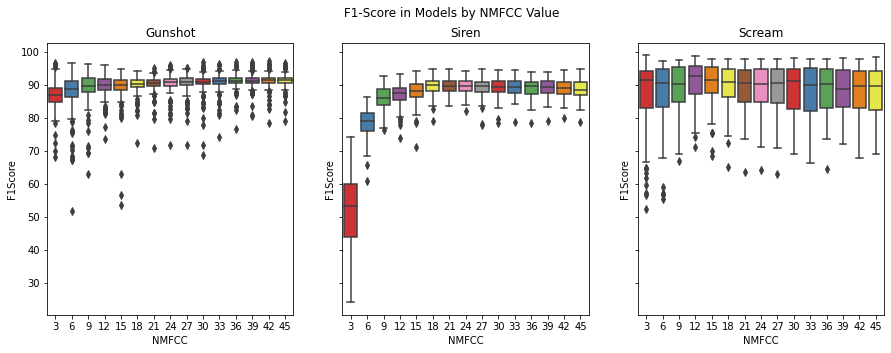

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('F1-Score in Models by NMFCC Value')


# Gunshot
sb.boxplot(ax=axes[0], x='NMFCC', y='F1Score', data=dfExperimentsGun, palette='Set1')
axes[0].set_title("Gunshot")

# Siren
sb.boxplot(ax=axes[1], x='NMFCC', y='F1Score', data=dfExperimentsSiren, palette='Set1')
axes[1].set_title("Siren")

# Scream
sb.boxplot(ax=axes[2], x='NMFCC', y='F1Score', data=dfExperimentsScream, palette='Set1')
axes[2].set_title("Scream")

[(80.0, 95.0)]

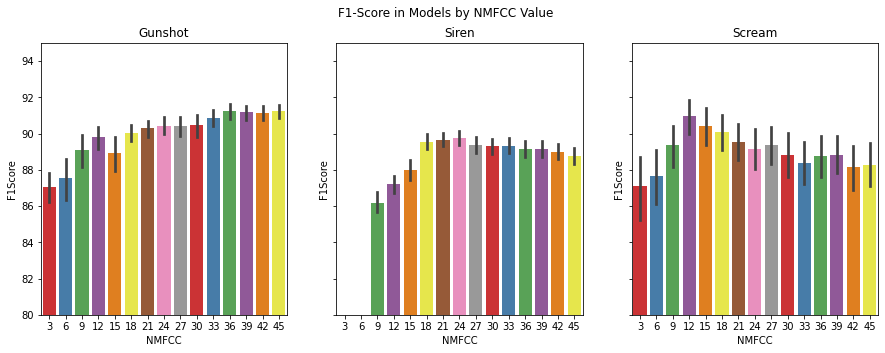

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('F1-Score in Models by NMFCC Value')


# Gunshot
sb.barplot(ax=axes[0], x='NMFCC', y='F1Score', data=dfExperimentsGun, palette='Set1')
axes[0].set_title("Gunshot")

# Siren
sb.barplot(ax=axes[1], x='NMFCC', y='F1Score', data=dfExperimentsSiren, palette='Set1')
axes[1].set_title("Siren")

# Scream
sb.barplot(ax=axes[2], x='NMFCC', y='F1Score', data=dfExperimentsScream, palette='Set1')
axes[2].set_title("Scream")
axes[2].set(ylim=(80, 95))

Text(0.5, 1.0, 'Scream')

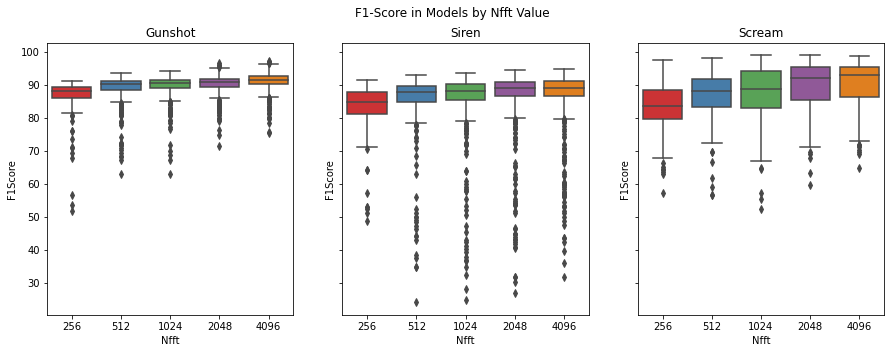

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('F1-Score in Models by Nfft Value')


# Gunshot
sb.boxplot(ax=axes[0], x='Nfft', y='F1Score', data=dfExperimentsGun, palette='Set1')
axes[0].set_title("Gunshot")

# Siren
sb.boxplot(ax=axes[1], x='Nfft', y='F1Score', data=dfExperimentsSiren, palette='Set1')
axes[1].set_title("Siren")

# Scream
sb.boxplot(ax=axes[2], x='Nfft', y='F1Score', data=dfExperimentsScream, palette='Set1')
axes[2].set_title("Scream")

[(80.0, 95.0)]

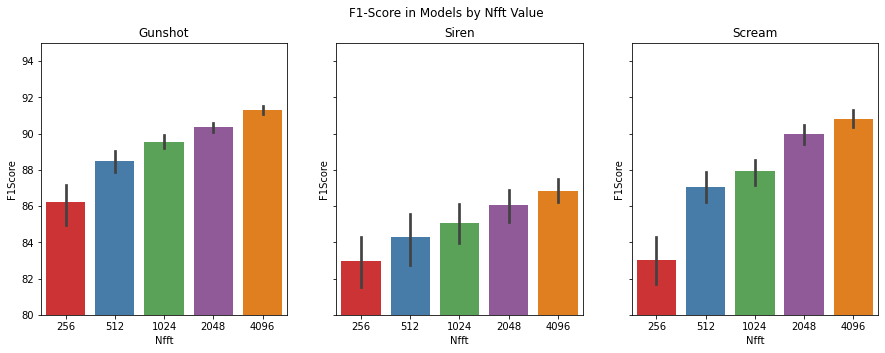

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('F1-Score in Models by Nfft Value')


# Gunshot
sb.barplot(ax=axes[0], x='Nfft', y='F1Score', data=dfExperimentsGun, palette='Set1')
axes[0].set_title("Gunshot")

# Siren
sb.barplot(ax=axes[1], x='Nfft', y='F1Score', data=dfExperimentsSiren, palette='Set1')
axes[1].set_title("Siren")

# Scream
sb.barplot(ax=axes[2], x='Nfft', y='F1Score', data=dfExperimentsScream, palette='Set1')
axes[2].set_title("Scream")
axes[2].set(ylim=(80, 95))

Text(0.5, 1.0, 'Scream')

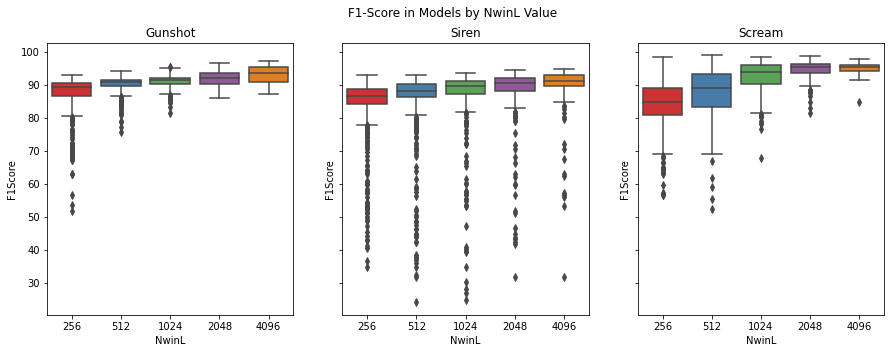

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('F1-Score in Models by NwinL Value')


# Gunshot
sb.boxplot(ax=axes[0], x='NwinL', y='F1Score', data=dfExperimentsGun, palette='Set1')
axes[0].set_title("Gunshot")

# Siren
sb.boxplot(ax=axes[1], x='NwinL', y='F1Score', data=dfExperimentsSiren, palette='Set1')
axes[1].set_title("Siren")

# Scream
sb.boxplot(ax=axes[2], x='NwinL', y='F1Score', data=dfExperimentsScream, palette='Set1')
axes[2].set_title("Scream")

[(80.0, 98.0)]

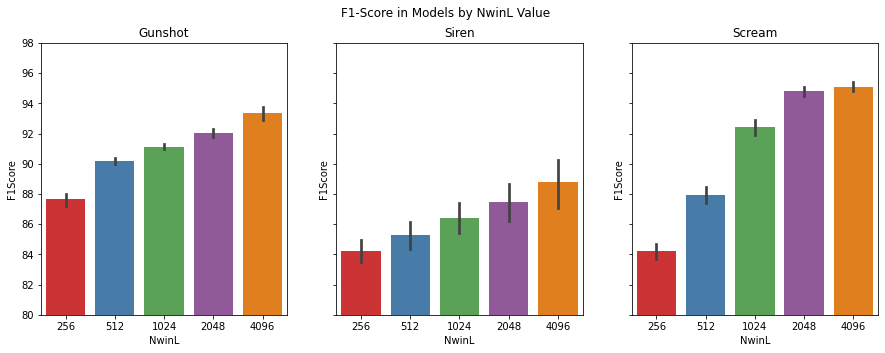

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('F1-Score in Models by NwinL Value')


# Gunshot
sb.barplot(ax=axes[0], x='NwinL', y='F1Score', data=dfExperimentsGun, palette='Set1')
axes[0].set_title("Gunshot")

# Siren
sb.barplot(ax=axes[1], x='NwinL', y='F1Score', data=dfExperimentsSiren, palette='Set1')
axes[1].set_title("Siren")

# Scream
sb.barplot(ax=axes[2], x='NwinL', y='F1Score', data=dfExperimentsScream, palette='Set1')
axes[2].set_title("Scream")
axes[2].set(ylim=(80, 98))

Text(0.5, 1.0, 'Scream')

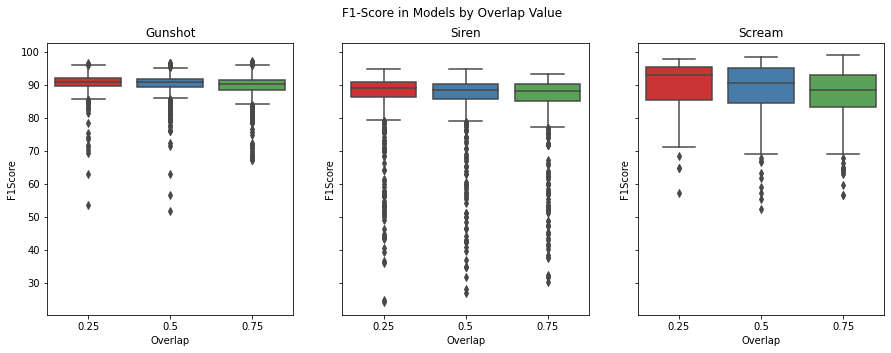

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('F1-Score in Models by Overlap Value')


# Gunshot
sb.boxplot(ax=axes[0], x='Overlap', y='F1Score', data=dfExperimentsGun, palette='Set1')
axes[0].set_title("Gunshot")

# Siren
sb.boxplot(ax=axes[1], x='Overlap', y='F1Score', data=dfExperimentsSiren, palette='Set1')
axes[1].set_title("Siren")

# Scream
sb.boxplot(ax=axes[2], x='Overlap', y='F1Score', data=dfExperimentsScream, palette='Set1')
axes[2].set_title("Scream")

[(80.0, 98.0)]

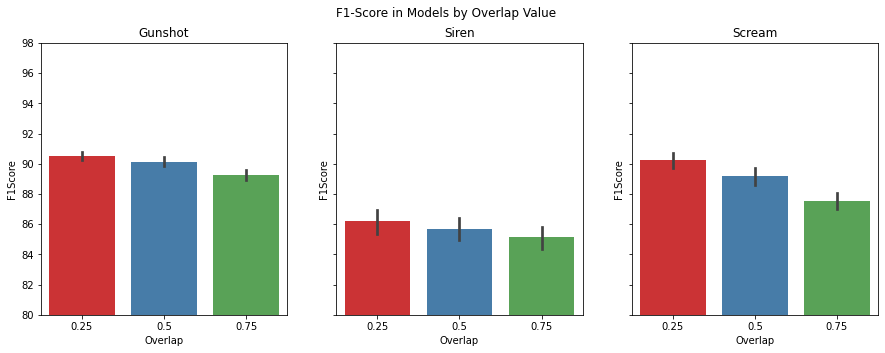

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('F1-Score in Models by Overlap Value')


# Gunshot
sb.barplot(ax=axes[0], x='Overlap', y='F1Score', data=dfExperimentsGun, palette='Set1')
axes[0].set_title("Gunshot")

# Siren
sb.barplot(ax=axes[1], x='Overlap', y='F1Score', data=dfExperimentsSiren, palette='Set1')
axes[1].set_title("Siren")

# Scream
sb.barplot(ax=axes[2], x='Overlap', y='F1Score', data=dfExperimentsScream, palette='Set1')
axes[2].set_title("Scream")
axes[2].set(ylim=(80, 98))

Text(0.5, 1.0, 'Scream')

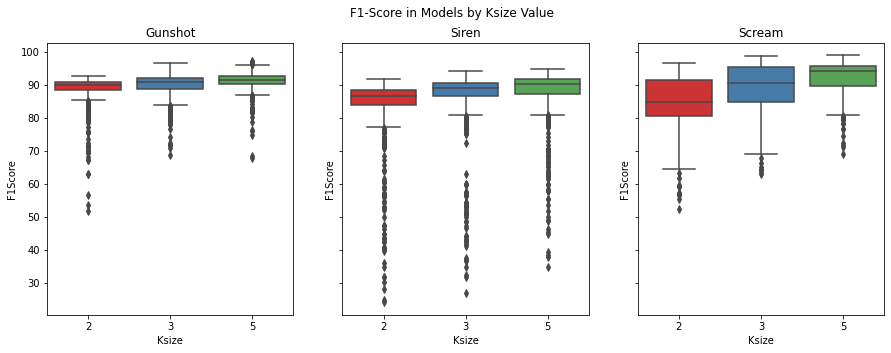

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('F1-Score in Models by Ksize Value')


# Gunshot
sb.boxplot(ax=axes[0], x='Ksize', y='F1Score', data=dfExperimentsGun, palette='Set1')
axes[0].set_title("Gunshot")

# Siren
sb.boxplot(ax=axes[1], x='Ksize', y='F1Score', data=dfExperimentsSiren, palette='Set1')
axes[1].set_title("Siren")

# Scream
sb.boxplot(ax=axes[2], x='Ksize', y='F1Score', data=dfExperimentsScream, palette='Set1')
axes[2].set_title("Scream")

[(80.0, 98.0)]

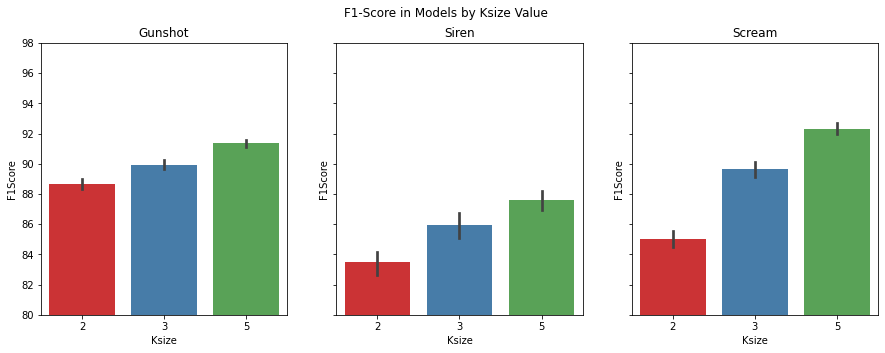

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('F1-Score in Models by Ksize Value')

# Gunshot
sns.barplot(ax=axes[0], x='Ksize', y='F1Score', data=dfExperimentsGun, palette='Set1')
axes[0].set_title("Gunshot")

# Siren
sns.barplot(ax=axes[1], x='Ksize', y='F1Score', data=dfExperimentsSiren, palette='Set1')
axes[1].set_title("Siren")

# Scream
sns.barplot(ax=axes[2], x='Ksize', y='F1Score', data=dfExperimentsScream, palette='Set1')
axes[2].set_title("Scream")

axes[2].set(ylim=(80, 98))

#PARETO POINTS ANALYSIS

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


def showParetoFront(AVGDataOutputPathFLOPS):
  # Cargar datos desde archivo CSV
  dfFlops = pd.read_csv(AVGDataOutputPathFLOPS)
  # Convertir métrica que se desea minimizar a su valor absoluto
  dfFlops['FLOPS'] = dfFlops['FLOPS'].abs()

  # Ordenar puntos por la variable que se desea minimizar
  dfSorted = dfFlops.sort_values(by='FLOPS')

  # Encontrar puntos de Pareto óptimos
  pareto_front = []
  max_f1score = -float('inf')
  for i, row in dfSorted.iterrows():
      if row['F1Score'] > max_f1score:
          pareto_front.append(i)
          max_f1score = row['F1Score']

  # Imprimir índices de puntos de Pareto óptimos
  print('Los índices de los puntos de Pareto óptimos son:')
  print(pareto_front)

  # Graficar datos y puntos de Pareto óptimos
  plt.scatter(dfFlops['FLOPS'], 100-dfFlops['F1Score'])
  plt.scatter(dfFlops.iloc[pareto_front]['FLOPS'], 100-dfFlops.iloc[pareto_front]['F1Score'], color='r')
  plt.xlabel('FLOPS')
  plt.ylabel('100 - F1Score')
  plt.show()

  return dfFlops, pareto_front


Los índices de los puntos de Pareto óptimos son:
[236, 232, 156, 237, 233, 1437, 1193, 1433, 1181, 2155]


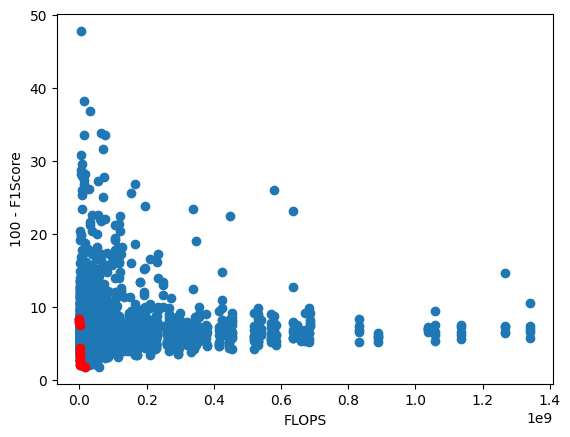

El DataFrame de los puntos de Pareto óptimos es:


,Unnamed: 0,NExp,NMFCC,Nfft,NwinL,NhopL,Overlap,Ksize,AVGPreprocesTime,AVGTrainTime,F1Score,TestAcc,EpochsRan,FLOPS,AVGVimPreprocessTime,AVGVimPredictTime,AVGVimTFLitePredictTime
236,236,237,3,4096,4096,4096,0.00,2,0 days 00:00:00.009461,0 days 00:00:53.823729,91.6,91.4,80,200374.0,0 days 00:00:00.058184,0 days 00:00:00.283825,0 days 00:00:00.000156
232,232,233,3,4096,4096,3072,0.25,2,0 days 00:00:00.012263,0 days 00:00:42.900707,92.0,92.2,69,268190.0,0 days 00:00:00.059563,0 days 00:00:00.273555,0 days 00:00:00.000173
156,156,157,3,2048,2048,2048,0.00,2,0 days 00:00:00.009038,0 days 00:00:38.454848,92.4,92.4,78,404574.0,0 days 00:00:00.047671,0 days 00:00:00.277317,0 days 00:00:00.000193
237,237,238,3,4096,4096,4096,0.00,3,0 days 00:00:00.009461,0 days 00:00:54.868634,95.6,95.6,79,446294.0,0 days 00:00:00.059510,0 days 00:00:00.280978,0 days 00:00:00.000245
233,233,234,3,4096,4096,3072,0.25,3,0 days 00:00:00.012263,0 days 00:00:53.430546,96.2,96.2,78,597710.0,0 days 00:00:00.057461,0 days 00:00:00.279771,0 days 00:00:00.000265
1437,1437,1438,18,4096,4096,4096,0.00,3,0 days 00:00:00.013483,0 days 00:00:45.225517,96.8,97.0,80,1743798.0,0 days 00:00:00.060245,0 days 00:00:00.283680,0 days 00:00:00.000526
1193,1193,1194,15,4096,4096,3072,0.25,3,0 days 00:00:00.009280,0 days 00:00:49.690640,97.2,97.4,80,1809998.0,0 days 00:00:00.056582,0 days 00:00:00.276245,0 days 00:00:00.000553
1433,1433,1434,18,4096,4096,3072,0.25,3,0 days 00:00:00.009860,0 days 00:00:44.619505,97.4,97.4,75,2337606.0,0 days 00:00:00.059368,0 days 00:00:00.284496,0 days 00:00:00.000617
1181,1181,1182,15,4096,2048,2048,0.00,3,0 days 00:00:00.014262,0 days 00:00:50.048719,98.0,98.0,78,2736910.0,0 days 00:00:00.060397,0 days 00:00:00.277748,0 days 00:00:00.000701
2155,2155,2156,27,4096,4096,3072,0.25,7,0 days 00:00:00.013589,0 days 00:00:45.816381,98.2,98.2,70,17950926.0,0 days 00:00:00.056849,0 days 00:00:00.275834,0 days 00:00:00.003850


In [ ]:

dfGunshotFlops, pareto_frontGun = showParetoFront(AVGDataOutputPathGunshotFLOPS)

# Crear DataFrame de los puntos de Pareto óptimos
pareto_df = dfGunshotFlops.iloc[pareto_frontGun, :]
# Imprimir DataFrame de puntos de Pareto óptimos
print('El DataFrame de los puntos de Pareto óptimos es:')
pareto_df

Los índices de los puntos de Pareto óptimos son:
[236, 232, 476, 472, 956, 712, 952, 473, 461, 2876, 953, 478, 3592, 2873, 874, 3273]


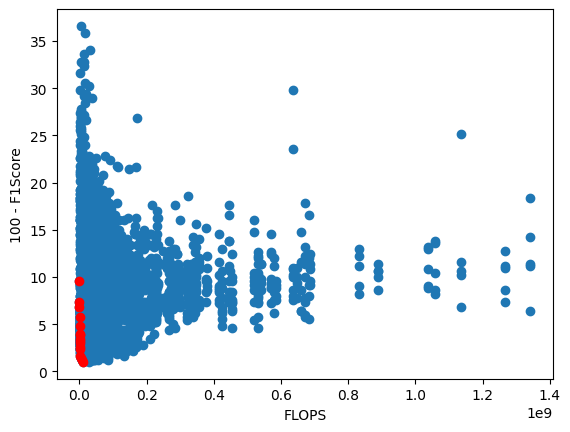

El DataFrame de los puntos de Pareto óptimos es:


,Unnamed: 0,NExp,NMFCC,Nfft,NwinL,NhopL,Overlap,Ksize,AVGPreprocesTime,AVGTrainTime,F1Score,TestAcc,EpochsRan,FLOPS,AVGVimPreprocessTime,AVGVimPredictTime,AVGVimTFLitePredictTime
236,236,237,3,4096,4096,4096,0.00,2,0 days 00:00:00.008809,0 days 00:01:11.735440,90.4,91.2,80,200374.0,0 days 00:00:00.054538,0 days 00:00:00.285917,0 days 00:00:00.000175
232,232,233,3,4096,4096,3072,0.25,2,0 days 00:00:00.016578,0 days 00:01:07.418086,92.6,93.0,80,268190.0,0 days 00:00:00.054518,0 days 00:00:00.273553,0 days 00:00:00.000174
476,476,477,6,4096,4096,4096,0.00,2,0 days 00:00:00.012219,0 days 00:01:07.832815,93.2,93.4,80,277910.0,0 days 00:00:00.053049,0 days 00:00:00.279203,0 days 00:00:00.000177
472,472,473,6,4096,4096,3072,0.25,2,0 days 00:00:00.011543,0 days 00:01:04.547991,94.2,94.6,76,372198.0,0 days 00:00:00.041675,0 days 00:00:00.280211,0 days 00:00:00.000197
956,956,957,12,4096,4096,4096,0.00,2,0 days 00:00:00.010105,0 days 00:01:06.358292,95.2,95.6,80,505190.0,0 days 00:00:00.048119,0 days 00:00:00.274415,0 days 00:00:00.000212
712,712,713,9,4096,4096,3072,0.25,2,0 days 00:00:00.009563,0 days 00:00:56.259803,96.0,96.4,79,639486.0,0 days 00:00:00.045443,0 days 00:00:00.284302,0 days 00:00:00.000254
952,952,953,12,4096,4096,3072,0.25,2,0 days 00:00:00.012227,0 days 00:00:56.275605,96.2,96.4,80,677190.0,0 days 00:00:00.051520,0 days 00:00:00.283185,0 days 00:00:00.000277
473,473,474,6,4096,4096,3072,0.25,3,0 days 00:00:00.011543,0 days 00:01:05.622494,96.6,96.6,80,828998.0,0 days 00:00:00.055073,0 days 00:00:00.477761,0 days 00:00:00.000325
461,461,462,6,4096,2048,2048,0.00,3,0 days 00:00:00.010643,0 days 00:01:06.046907,96.8,96.8,79,1251718.0,0 days 00:00:00.057267,0 days 00:00:00.276251,0 days 00:00:00.000368
2876,2876,2877,36,4096,4096,4096,0.00,2,0 days 00:00:00.011268,0 days 00:01:12.901940,97.0,97.0,80,1416166.0,0 days 00:00:00.050960,0 days 00:00:00.283819,0 days 00:00:00.000461


In [ ]:
dfScreamFlops, pareto_frontScream = showParetoFront(AVGDataOutputPathScreamFLOPS)

# Crear DataFrame de los puntos de Pareto óptimos
pareto_df = dfScreamFlops.iloc[pareto_frontScream, :]
# Imprimir DataFrame de puntos de Pareto óptimos
print('El DataFrame de los puntos de Pareto óptimos es:')
pareto_df

#PARTIAL CORRELATION ANALYSIS

In [ ]:
!pip install pingouin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7029 sha256=f794d8a04f535d6d015d27e6247ec348e00a90f7b5f4efcd535ec8c68dfc41e8
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


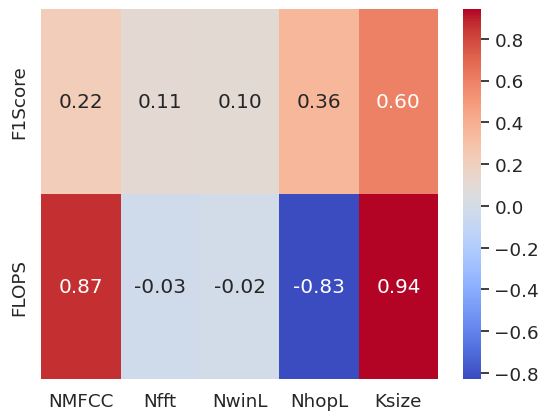

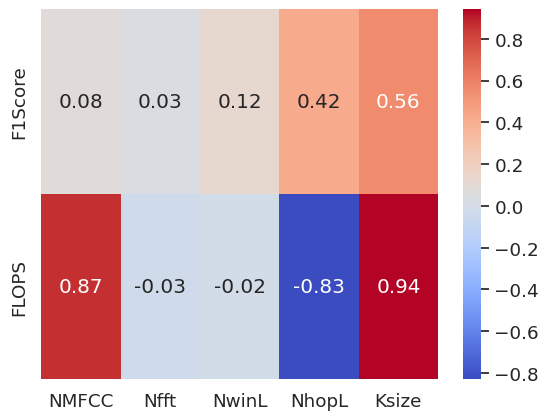

In [ ]:
# only "pearson" and "spearman" are supported for partial correlation.

import pandas as pd
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt

def partial_corr_matrix(data, method='pearson', interest_col=[]):
    dataNew = pd.DataFrame(data, columns=data.columns.values)
    corr_matrix = dataNew.corr(method=method)
    out_partial_corr_matrix = pd.DataFrame(index=interest_col, columns=['NMFCC', 'Nfft', 'NwinL', 'NhopL', 'Ksize']).fillna(0.0)
    for value in interest_col:
      columns = list(data.columns.values)
      columns.remove(value)
      dataNew = pd.DataFrame(data, columns=columns)
      corr_matrix = dataNew.corr(method=method)
      temp_partial_corr_matrix = pd.DataFrame(index=corr_matrix.index, columns=corr_matrix.columns).fillna(0.0)
      for col1 in corr_matrix.columns:
          for col2 in corr_matrix.columns:
              if col1 != col2:
                  control_cols = [col for col in corr_matrix.columns if col != col1 and col != col2]
                  partial_corr = pg.partial_corr(data=data, x=col1, y=col2, covar=control_cols, method=method)['r']
                  temp_partial_corr_matrix.loc[col1, col2] = partial_corr[0]
      temp_partial_corr_matrix = temp_partial_corr_matrix.drop(labels=['NMFCC', 'Nfft', 'NwinL', 'NhopL', 'Ksize'], axis=0)
      interest_col_copy = interest_col.copy()
      interest_col_copy.remove(value)
      temp_partial_corr_matrix = temp_partial_corr_matrix.drop(labels=interest_col_copy, axis=1)
      out_partial_corr_matrix.loc[interest_col_copy] = temp_partial_corr_matrix.loc[interest_col_copy]
    return out_partial_corr_matrix



AVGDataOutputPathGunFLOPS = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_gunshot_flops.csv"
dfExperimentsGun = pd.read_csv(AVGDataOutputPathGunFLOPS, index_col=0)

# Leer datos desde un archivo CSV
columns = ['NMFCC', 'Nfft', 'NwinL', 'NhopL', 'Ksize', 'F1Score', 'FLOPS']
dfExperimentsGunKC = pd.DataFrame(dfExperimentsGun, columns=columns)
# Crear un dataframe con las variables de interés
data_vars_interes = dfExperimentsGunKC[['NMFCC', 'Nfft', 'NwinL', 'NhopL', 'Ksize', 'F1Score', 'FLOPS']]

'''sns.set(font_scale=1.2)
# Calcular la matriz de correlaciones parciales para Pearson
partial_corr_pearson = partial_corr_matrix(dfExperimentsGunKC, method='pearson').fillna(0)
sns.heatmap(partial_corr_pearson, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlación parcial - Pearson')
plt.show()'''

# Calcular la matriz de correlaciones parciales para Spearman
partial_corr_spearman = partial_corr_matrix(dfExperimentsGunKC, method='spearman', interest_col=['F1Score', 'FLOPS']).fillna(0)
sns.set(font_scale=1.2)
sns.heatmap(partial_corr_spearman, cmap='coolwarm', annot=True, fmt='.2f')
#plt.title('Correlación parcial - Spearman - Gunshot')
plt.show()


'''# Leer datos desde un archivo CSV
columns = ['NMFCC', 'Nfft', 'NwinL', 'NhopL', 'Ksize', 'F1Score', 'FLOPS']
dfExperimentsSirenKC = pd.DataFrame(dfExperimentsSiren, columns=columns)
# Crear un dataframe con las variables de interés
data_vars_interes = dfExperimentsSirenKC[['NMFCC', 'Nfft', 'NwinL', 'NhopL', 'Ksize', 'F1Score', 'FLOPS']]'''

'''sns.set(font_scale=1.2)
# Calcular la matriz de correlaciones parciales para Pearson
partial_corr_pearson = partial_corr_matrix(dfExperimentsSirenKC, method='pearson').fillna(0)
sns.heatmap(partial_corr_pearson, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlación parcial - Pearson')
plt.show()'''

'''# Calcular la matriz de correlaciones parciales para Spearman
partial_corr_spearman = partial_corr_matrix(dfExperimentsSirenKC, method='spearman', interest_col=['F1Score', 'FLOPS']).fillna(0)
sns.set(font_scale=1.2)
sns.heatmap(partial_corr_spearman, cmap='coolwarm', annot=True, fmt='.2f')
#plt.title('Correlación parcial - Spearman - Siren')
plt.show()'''

AVGDataOutputPathScreamFLOPS = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models_V2/output_data/AVG_data_out_scream_flops.csv"
dfExperimentsScream = pd.read_csv(AVGDataOutputPathScreamFLOPS, index_col=0)

# Leer datos desde un archivo CSV
columns = ['NMFCC', 'Nfft', 'NwinL', 'NhopL', 'Ksize', 'F1Score', 'FLOPS']
dfExperimentsScreamKC = pd.DataFrame(dfExperimentsScream, columns=columns)
# Crear un dataframe con las variables de interés
data_vars_interes = dfExperimentsScreamKC[['NMFCC', 'Nfft', 'NwinL', 'NhopL', 'Ksize', 'F1Score', 'FLOPS']]

'''sns.set(font_scale=1.2)
# Calcular la matriz de correlaciones parciales para Pearson
partial_corr_pearson = partial_corr_matrix(dfExperimentsGunKC, method='pearson').fillna(0)
sns.heatmap(partial_corr_pearson, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlación parcial - Pearson')
plt.show()'''

# Calcular la matriz de correlaciones parciales para Spearman
partial_corr_spearman = partial_corr_matrix(dfExperimentsScreamKC, method='spearman', interest_col=['F1Score', 'FLOPS']).fillna(0)
sns.set(font_scale=1.2)
sns.heatmap(partial_corr_spearman, cmap='coolwarm', annot=True, fmt='.2f')
#plt.title('Correlación parcial - Spearman - Scream ')
plt.show()